In [111]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp

In [2]:
feddata = pd.read_feather("..\\processeddata\\feddata_synced.feather")  

In [3]:
feddata

,t,event,fr,device_number,ipi,poke_time,mouseid,diet,sex,mode,choice_session,batch,fed_pellet
0,2023-03-29 08:50:17,LeftWithPellet,0,1,NaN,0.56,FEDXDF1,PR,F,FF,ZERO,1,MIX
1,2023-03-29 08:50:44,LeftWithPellet,0,1,NaN,0.72,FEDXDF1,PR,F,FF,ZERO,1,MIX
2,2023-03-29 08:53:08,LeftWithPellet,0,1,NaN,0.40,FEDXDF1,PR,F,FF,ZERO,1,MIX
3,2023-03-29 08:55:42,LeftWithPellet,0,1,NaN,1.15,FEDXDF1,PR,F,FF,ZERO,1,MIX
4,2023-03-29 08:55:46,RightWithPellet,0,1,NaN,0.05,FEDXDF1,PR,F,FF,ZERO,1,MIX
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238188,2023-04-26 07:51:20,Left,9,8,NaN,1.25,FEDXDM20,NR,M,CE,FOUR,4,SUC
238189,2023-04-26 07:51:22,Left,9,8,NaN,0.49,FEDXDM20,NR,M,CE,FOUR,4,SUC
238190,2023-04-26 07:51:23,Pellet,9,8,660.0,NaN,FEDXDM20,NR,M,CE,FOUR,4,SUC
238191,2023-04-26 09:02:01,Left,1,8,NaN,0.88,FEDXDM20,NR,M,CE,FOUR,4,SUC


In [6]:
ffdata = feddata.query("choice_session == 'ZERO' & mode == 'FR' & event == 'Pellet'")

In [7]:
len(ffdata)

11923

In [14]:
# check pellet intake under free-feeding mode with mixed pellets available

mice = ffdata.mouseid.unique()

NR, PR = [], []

for mouse in mice:
    temp_df = ffdata.query("mouseid == @mouse")
    if "NR" in temp_df.diet.unique():
        NR.append(len(temp_df))
    elif "PR" in temp_df.diet.unique():
        PR.append(len(temp_df))
    else:
        print(f"no valid diet option for {mouse}")

[Text(0, 0, 'NR'), Text(1, 0, 'PR')]

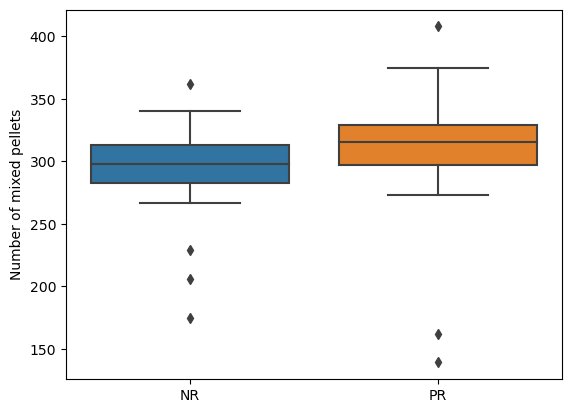

In [22]:
# number of pellets consumed in free-feeding mode
f, ax = plt.subplots()
sns.boxplot(data=[NR, PR], ax=ax);
ax.set_ylabel("Number of mixed pellets")
ax.set_xticklabels(["NR", "PR"])

In [24]:
# check learning rate when switched to FR1
frdata = ffdata = feddata.query("choice_session == 'ZERO' & mode == 'FR'")

In [25]:
frdata.event.unique()

array(['Right', 'Left', 'Pellet', 'LeftDuringDispense', 'LeftWithPellet',
       'RightWithPellet', 'LeftinTimeOut', 'RightDuringDispense',
       'RightinTimeout'], dtype=object)

In [34]:
frdata_active = frdata.query("event == 'Left' | event == 'LeftWithPellet' | event == 'LeftDuringDispense' | event == 'LeftinTimeout'")
frdata_inactive = frdata.query("event == 'Right' | event == 'RightWithPellet' | event == 'RightDuringDispense' | event == 'RightinTimeout'")


In [35]:
print("Number of active pokes={} vs. inactive pokes={}".format(len(frdata_active), len(frdata_inactive)))

Number of active pokes=13291 vs. inactive pokes=3891


In [46]:
mice = frdata.mouseid.unique()

NR_active, NR_inactive, PR_active, PR_inactive = [], [], [], []

for mouse in mice:
    temp_active = frdata_active.query("mouseid == @mouse")
    temp_inactive = frdata_inactive.query("mouseid == @mouse")
    if "NR" in temp_active.diet.unique():
        NR_active.append(len(temp_active))
        NR_inactive.append(len(temp_inactive))
    elif "PR" in temp_active.diet.unique():
        PR_active.append(len(temp_active))
        PR_inactive.append(len(temp_inactive))
    else:
        print(f"no valid diet option for {mouse}")

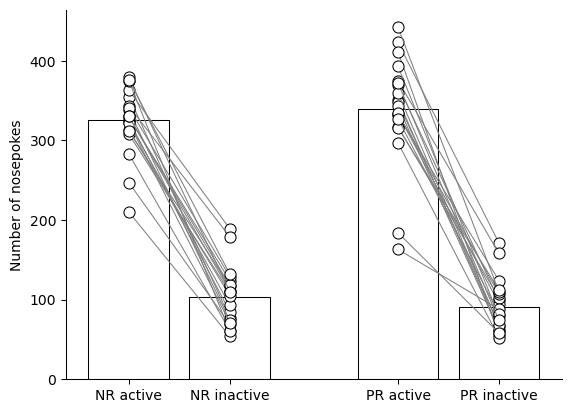

In [53]:
# number of nose pokes for active and inactive ports
f, ax = plt.subplots()
_, barx, _, _ = tp.barscatter([[NR_active, NR_inactive], [PR_active, PR_inactive]],
              paired=True,
              ax=ax);
ax.set_ylabel("Number of nosepokes")
ax.set_xticks(barx, labels=["NR active", "NR inactive", "PR active", "PR inactive"])

In [93]:
# calculating the learning rate by showing cumulative sum of active and inactive pokes
def get_cumsum(df):
    
    return (df
            .resample(rule="H", on="t", offset='09h00min')
            .count()
            .assign(t=lambda dt: dt.index - dt.first_valid_index())
            .set_index('t')
            .event
            .cumsum()
            )

mice = frdata.mouseid.unique()

NR_active, NR_inactive, PR_active, PR_inactive = [], [], [], []

for mouse in mice:
    temp_active = frdata_active.query("mouseid == @mouse")
    temp_inactive = frdata_inactive.query("mouseid == @mouse")
    if "NR" in temp_active.diet.unique():
        NR_active.append(get_cumsum(temp_active))
        NR_inactive.append(get_cumsum(temp_inactive))
    elif "PR" in temp_active.diet.unique():
        PR_active.append(get_cumsum(temp_active))
        PR_inactive.append(get_cumsum(temp_inactive))
    else:
        print(f"no valid diet option for {mouse}")
        
## need to add in correction for slow learners

In [88]:
x = NR_active[0]

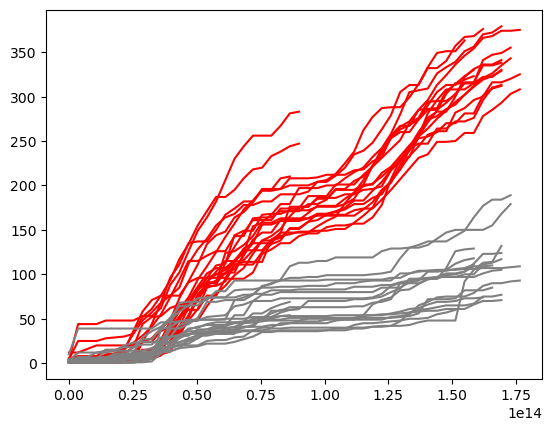

In [98]:
for i in NR_active:
    plt.plot(i, color="red")
for j in NR_inactive:
    plt.plot(j, color="grey")


In [115]:


def pad_series(df, length):

    pad_value = df.max()

    num_elements_to_pad = length - len(df)

    return (df
            #.reset_index(drop=True)
            .append(pd.Series([pad_value] * num_elements_to_pad), ignore_index=True)
           )

def make_padded_cumsum_array(list_of_dfs):
    
    cs_array = []
    for df in list_of_dfs:
        if len(df) < 26:
            print("uh-oh")
        cs_array.append(pad_series(df, 50))
    

    return np.array(cs_array)

NR_active_cs = make_padded_cumsum_array(NR_active)
NR_inactive_cs = make_padded_cumsum_array(NR_inactive)

PR_active_cs = make_padded_cumsum_array(PR_active)
PR_inactive_cs = make_padded_cumsum_array(PR_inactive)


uh-oh
uh-oh
uh-oh
uh-oh
uh-oh
uh-oh
uh-oh


C:\Users\jmc010\AppData\Local\Temp\ipykernel_18480\72750465.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return (df
C:\Users\jmc010\AppData\Local\Temp\ipykernel_18480\72750465.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .append(pd.Series([pad_value] * num_elements_to_pad), ignore_index=True)


<Axes: >

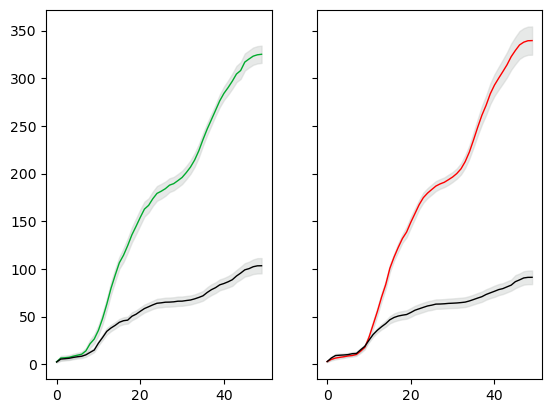

In [128]:
f, [ax1, ax2] = plt.subplots(ncols=2, sharey=True)
tp.shadedError(ax1, NR_active_cs, linecolor="xkcd:kelly green")
tp.shadedError(ax1, NR_inactive_cs, linecolor="black")

tp.shadedError(ax2, PR_active_cs, linecolor="red")
tp.shadedError(ax2, PR_inactive_cs, linecolor="black")

In [67]:
test.resample?

In [ ]:
            .reset_index()
            .assign(t=lambda df_: [dt.replace(day=1, month=1) for dt in df_.t])
            .set_index("t")
            .resample("H")